In [6]:
%pip install matplotlib
%pip install pandasgui

Note: you may need to restart the kernel to use updated packages.
  Using cached pandasgui-0.2.15-py3-none-any.whl
  Using cached PyQtWebEngine-5.15.7-cp38-abi3-manylinux_2_17_x86_64.whl.metadata (1.8 kB)
  Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached qtstylish-0.1.5-py3-none-any.whl
Using cached PyQtWebEngine-5.15.7-cp38-abi3-manylinux_2_17_x86_64.whl (227 kB)
Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandasgui]/4 [pandasgui]
Note: you may need to restart the kernel to use updated packages.


Detected RAG variants: ['Basic RAG', 'Contextual Hybrid RAG', 'Contextual RAG', 'Hybrid RAG']


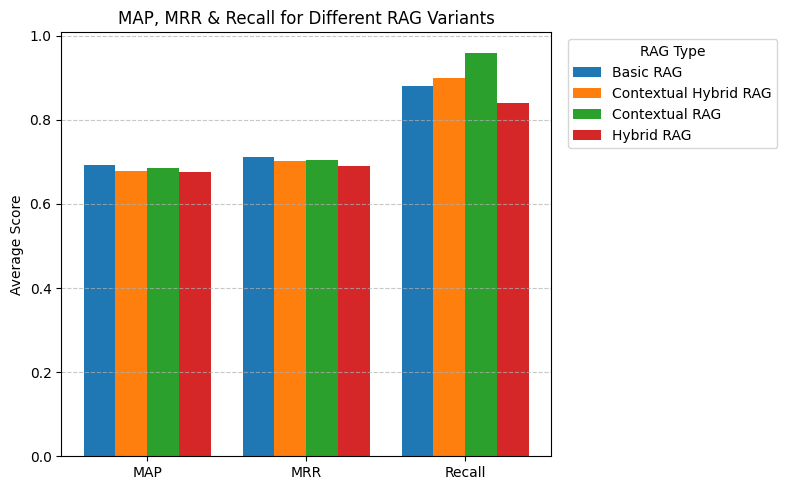

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your DataFrame
df = pd.read_pickle("results/retrieval_eval_results_QwenQwen3-Embedding-4B_topk5.pkl")

# The metrics/suffixes you care about
metrics       = ["map", "mrr", "recall"]
metric_labels = ["MAP", "MRR", "Recall"]

# Dynamically grab just the prefixes that have all three metric columns
all_prefixes = {col.rsplit("_",1)[0] for col in df.columns}
rag_types = sorted(
    prefix for prefix in all_prefixes
    if all(f"{prefix}_{m}" in df.columns for m in metrics)
)

print("Detected RAG variants:", rag_types)
# → ['Basic RAG', 'Contextual RAG', 'Contextual Hybrid RAG', 'Hybrid RAG']


def mean_from_list_col(series: pd.Series) -> float:
    cleaned = (
        series
        .dropna()
        .apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x)
        .astype(float)
    )
    return cleaned.mean()

# Build a dict of mean‐values for each metric
metric_means = {m: [] for m in metrics}
for prefix in rag_types:
    for m in metrics:
        metric_means[m].append(mean_from_list_col(df[f"{prefix}_{m}"]))

# plotting
x = np.arange(len(metrics))
total_width = 0.8
bar_width   = total_width / len(rag_types)
offsets     = np.linspace(-total_width/2 + bar_width/2,
                          +total_width/2 - bar_width/2,
                          len(rag_types))

plt.figure(figsize=(8, 5))
for i, prefix in enumerate(rag_types):
    heights = [metric_means[m][i] for m in metrics]
    plt.bar(x + offsets[i], heights, bar_width, label=prefix)

plt.xticks(x, metric_labels)
plt.ylabel("Average Score")
plt.title("MAP, MRR & Recall for Different RAG Variants")
plt.legend(title="RAG Type", bbox_to_anchor=(1.02, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
df["Basic RAG_recall"].max()

np.float64(1.0)

In [9]:
df

,question,references,groundTruth,source_file,documents,variant,prev_messages,Basic RAG_map,Basic RAG_mrr,Basic RAG_recall,Hybrid RAG_map,Hybrid RAG_mrr,Hybrid RAG_recall,Contextual RAG_map,Contextual RAG_mrr,Contextual RAG_recall,Contextual Hybrid RAG_map,Contextual Hybrid RAG_mrr,Contextual Hybrid RAG_recall
0,Wie läuft eine äußere Wendung ab und was passi...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=42e5316808b9457eed1b32ec3d3a591b2...,default,[],0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Und wie lange dauert dieser Eingriff normalerw...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=42e5316808b9457eed1b32ec3d3a591b2...,contextual,"[Wie läuft eine äußere Wendung ab?, Bei der äu...",0.833333,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Ey, wie machen die eigentlich so 'ne äußere We...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=42e5316808b9457eed1b32ec3d3a591b2...,slang,[],1.000000,1.0,1.0,0.500000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,How is an external version done and what happe...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=42e5316808b9457eed1b32ec3d3a591b2...,english,[],0.500000,0.5,1.0,0.166667,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Können Sie mir erklären, wie eine äußere Wendu...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=42e5316808b9457eed1b32ec3d3a591b2...,german-variation-1,[],1.000000,1.0,1.0,0.500000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,"Was ist zu tun, wenn nach der Geburtseinleitun...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8cbfd372f826aeb040aa026c9155ccd35...,german-variation-2,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,"Kann mir jemand sagen, was ich machen soll, we...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8cbfd372f826aeb040aa026c9155ccd35...,german-variation-3,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,Ich hatte eine Geburtseinleitung – was mache i...,[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8cbfd372f826aeb040aa026c9155ccd35...,german-variation-4,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,"Was empfehlen Sie, wenn nach der Einleitung de...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8cbfd372f826aeb040aa026c9155ccd35...,german-variation-5,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from pandasgui import show

gui = show(df)

ImportError: this platform is not supported: ('failed to acquire X connection: Bad display name ""', DisplayNameError(''))

Try one of the following resolutions:

 * Please make sure that you have an X server running, and that the DISPLAY environment variable is set correctly